In [1]:
import numpy as np
import os
import sys
import glob
import cv2
import PIL
import random
import openslide
import skimage.io
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
#Misc imports
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook as tqdm
import albumentations
import time

In [3]:
#Torch imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler

device = torch.device('cuda')

In [126]:
from transformers import AutoImageProcessor, Swinv2Config, Swinv2Model

In [5]:
BASE_PATH = "/home/ubuntu/panda_data"
data_folder = os.path.join(BASE_PATH, "train_images")
masks_path = os.path.join(BASE_PATH, "train_label_masks")

all_df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))

images = list(all_df['image_id'])
labels = list(all_df['isup_grade'])

all_df

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
10612,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
10613,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative
10614,ffe236a25d4cbed59438220799920749,radboud,2,3+4


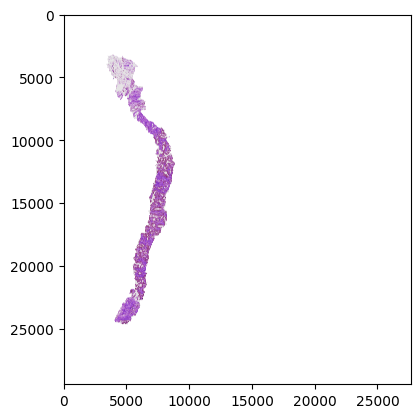

In [6]:
# Visualize one image
image = skimage.io.MultiImage(os.path.join(data_folder, all_df.iloc[0]["image_id"] + ".tiff"))
image = cv2.cvtColor(image[-1], cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()  

In [7]:
image.shape

(29440, 27648, 3)

In [115]:
create_patches(image[-1])[0][0]["patches"]

array([[[201,  67, 149],
        [203,  68, 150],
        [211,  76, 157],
        ...,
        [199,  84, 173],
        [195,  84, 170],
        [186,  82, 166]],

       [[190,  56, 139],
        [191,  57, 140],
        [196,  61, 144],
        ...,
        [203,  88, 177],
        [199,  88, 175],
        [181,  77, 161]],

       [[194,  61, 144],
        [196,  63, 146],
        [196,  63, 146],
        ...,
        [204,  90, 178],
        [206,  95, 183],
        [185,  81, 167]],

       ...,

       [[218, 164, 206],
        [209, 150, 196],
        [197, 135, 188],
        ...,
        [ 61,  21, 101],
        [ 67,  27,  97],
        [ 60,  19,  84]],

       [[196, 143, 192],
        [208, 152, 199],
        [220, 164, 209],
        ...,
        [ 83,  42, 121],
        [ 72,  27, 104],
        [ 61,  13,  88]],

       [[218, 168, 221],
        [206, 153, 200],
        [225, 174, 213],
        ...,
        [ 69,  25, 106],
        [ 62,  11,  96],
        [ 83,  26, 113]]

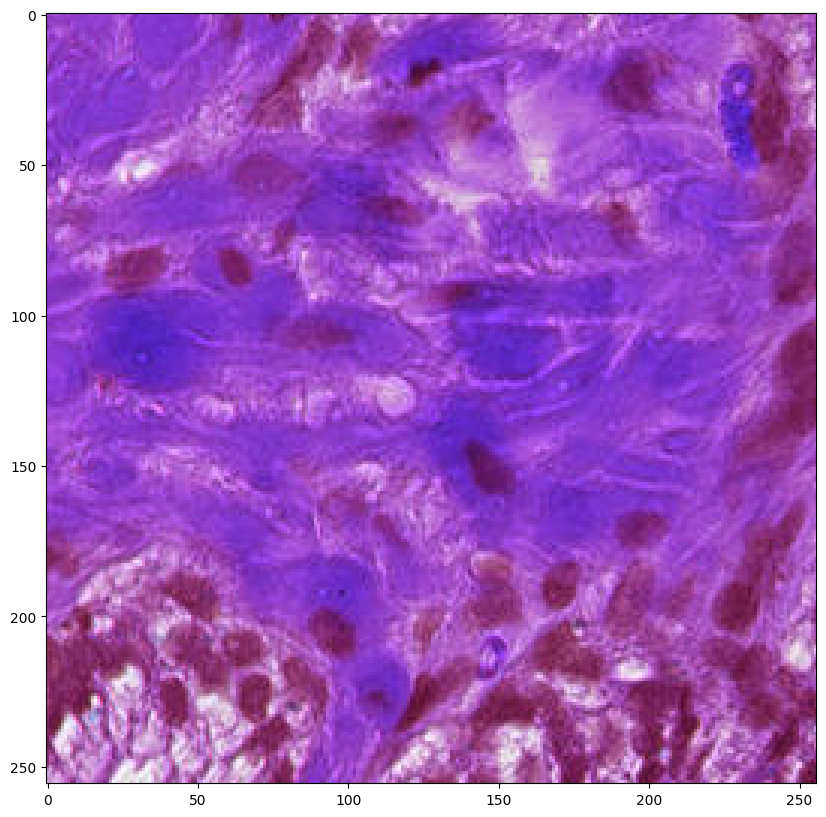

In [116]:
image = skimage.io.MultiImage(os.path.join(data_folder, all_df.iloc[0]["image_id"] + ".tiff"))
image = cv2.cvtColor(create_patches(image[-1])[0][0]["patches"], cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()  

In [7]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
all_df['fold'] = -1
for i, (train_idx, test_idx) in enumerate(skf.split(all_df, all_df['isup_grade'])):
    # Set up testing fold
    all_df.loc[test_idx, 'fold'] = i
all_df.head(20)

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,4
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3,3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3,0
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3,4


In [49]:
# Create patches from WSI image
#If > 95% of tile is white, flag that tile

# TO-DO: Add caching for patches to save compute time
def create_patches(img):
    patch_size, image_size = 256, 256
    n_patches = 36
    batch_size = 2
    num_workers = 4
    
    patches = []
    H, W, _ = img.shape
    pad_h = (patch_size - H % patch_size) % patch_size 
    pad_w = (patch_size - W % patch_size) % patch_size  
    
    # Pad with white
    padded_img = np.pad(img, [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0,0]], constant_values=255)
    padded_img = padded_img.reshape(padded_img.shape[0] // patch_size, # number of tiles in h-dimension
            patch_size,
            padded_img.shape[1] // patch_size, # number of tiles in width dimension
            patch_size,
            3)

    padded_img = padded_img.transpose(0,2,1,3,4).reshape(-1, patch_size, patch_size, 3)
    useful_patches = (padded_img.reshape(padded_img.shape[0], -1).sum(1) < (0.95 * (patch_size ** 2) * 3 * 255)).sum()
    if len(padded_img) < n_patches:
        padded_img = np.pad(padded_img, [[0, n_tiles - len(padded_img)], [0,0], [0,0], [0,0]], constant_values=255)
    # select most representative tiles
    indices = np.argsort(padded_img.reshape(padded_img.shape[0],-1).sum(-1))[:n_patches]
    filtered_img = padded_img[indices]
    for i in range(len(filtered_img)):
        patches.append({'patches': filtered_img[i], 'idx': i})
    return patches, useful_patches >= n_patches


In [4]:
class PandaDataset(Dataset):
    def __init__(self, df, image_size, n_tiles = 36, transforms=None):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transforms
    def __len__(self):
        return len(self.df)
    # Custom get item function
    def __getitem__(self, idx):
        if idx > len(self.df):
            idx = len(self.df) - 1
        img_path = os.path.join(data_folder, f"{self.df.iloc[idx]['image_id']}.tiff")
        indices = list(range(self.n_tiles))
        img = skimage.io.MultiImage(img_path)[-1]
        patches, keep_slide = create_patches(img)
        
        rows = int(np.sqrt(self.n_tiles))
        imgs = np.zeros((self.image_size * rows, self.image_size * rows, 3))
        for h in range(rows):
            for w in range(rows):
                curr_idx = h * rows + w
                if indices[curr_idx] < len(patches):
                    curr_img = patches[indices[curr_idx]]['patches']
                else:
                    # White tile
                    curr_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                # Remove white background
                curr_img = 255 - curr_img
                if self.transform is not None:
                    curr_img = self.transform(image=curr_img)['image']
                h_scaled = h * self.image_size
                w_scaled = w * self.image_size
                imgs[h_scaled : h_scaled + self.image_size, w_scaled : w_scaled + self.image_size] = curr_img

        if self.transform is not None:
            imgs = self.transform(image=imgs)['image']
        imgs = imgs.astype(np.float64)
        # Normalize back to 0-255
        imgs /= 255
        imgs = imgs.transpose(2, 0, 1)
        
        # 5 classes w/ binning label
        labels = np.zeros(5).astype(np.float32)
        labels[: self.df.iloc[idx]["isup_grade"]] = 1.
        return torch.tensor(imgs), torch.tensor(labels)

In [9]:
# Create transforms of patches
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])

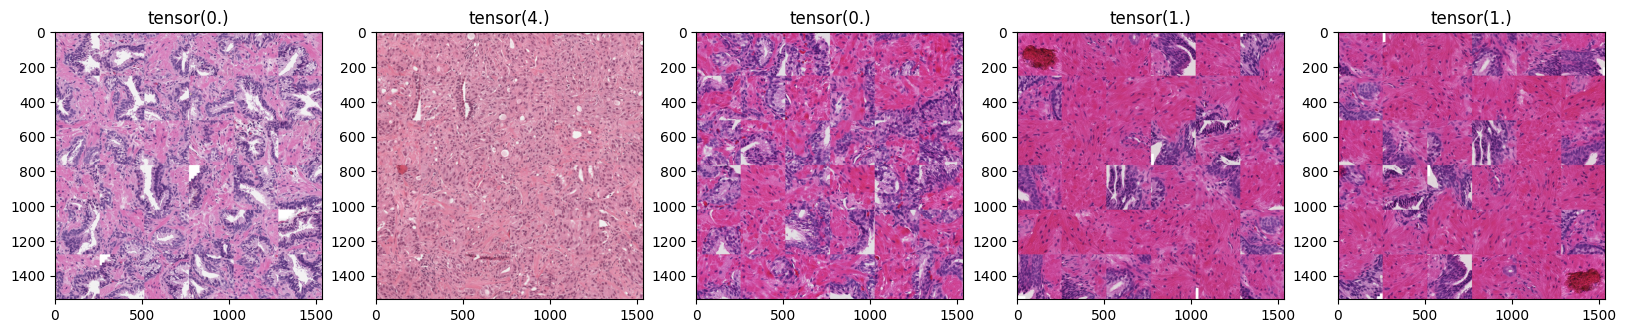

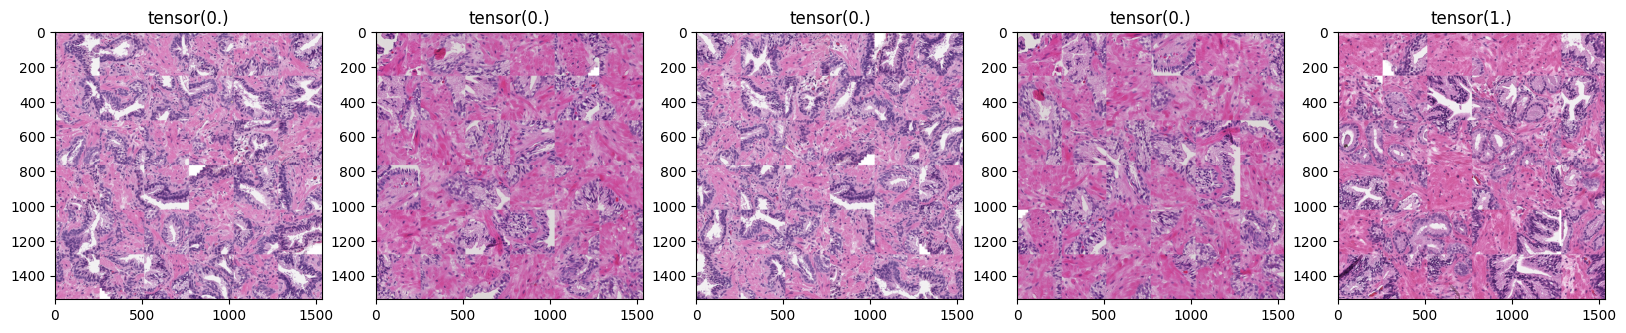

In [84]:
# Visualize patches
viz_data = PandaDataset(all_df.head(10), 256, 36, transforms=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, ax = plt.subplots(1,5)
    for p in range(5):
        rand_idx = np.random.randint(0, len(viz_data))
        img, label = viz_data[rand_idx]
        ax[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        ax[p].set_title(str(sum(label)))

In [13]:
# Load tiles into train/test dataloaders 
df_train = all_df.loc[np.where((all_df["fold"] != 0))[0]]
df_test = all_df.loc[np.where((all_df["fold"] == 0))[0]]

train_loader = PandaDataset(df_train, 256, 36, transforms=transforms_train)
test_loader = PandaDataset(df_test, 256, 36, transforms=None)

train_loader = torch.utils.data.DataLoader(train_loader, batch_size=10, sampler=RandomSampler(train_loader),
                                            num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=10, sampler=RandomSampler(train_loader),
                                            num_workers = 2)

In [14]:
len(test_loader)

85

In [128]:
# WSI classification: Densenet-121, Swin Transformer
densenet = torchvision.models.densenet121(pretrained=True)
num_features = densenet.classifier.in_features
num_classes = 5 
densenet.classifier = nn.Linear(num_features, num_classes)

for param in densenet.parameters():
    param.requires_grad = False

#Freeze other layers
num_layers = len(list(densenet.children()))
for i, child in enumerate(densenet.children()):
    if i > num_layers - 3:
        for param in child.parameters():
            param.requires_grad = True


#configuration = Swinv2Config()
#model = Swinv2Model(configuration).to(device)

model = densenet.to(device)
model.cuda()

/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [131]:
loss_func = nn.BCEWithLogitsLoss()

def train_loop(loader, opt):
    model.train()
    train_loss = []
    #preds, targets = [], []
    for (data, label) in loader:
        data, label = data.to(device, dtype=torch.float), label.to(device, dtype=torch.float)
        opt.zero_grad()
        logits = model(data)
        loss = loss_func(logits, label)
        #pred = logits.sigmoid().sum(1).detach().round()
        #preds.append(pred)
        #targets.append(label.sum(1))
        
        loss.backward()
        opt.step()
        train_loss.append(loss.detach().cpu().numpy())
    return train_loss

def test_loop(loader):
    test_loss = []
    preds, targets = [], []
    with torch.no_grad():
        for (data, label) in loader:
            data, label = data.to(device, dtype=torch.float), label.to(device, dtype=torch.float)
            logits = model(data)
            loss = loss_func(logits, label)
            # Get pred by taking sigmoid of logits
            pred = logits.sigmoid().sum(1).detach().round()
            preds.append(pred)
            # Sum over bins
            targets.append(label.sum(1))
            
            test_loss.append(loss.detach().cpu().numpy())
        final_test_loss = np.mean(test_loss)
    
    preds = torch.cat(preds).cpu().numpy()
    targets = torch.cat(targets).cpu().numpy()
    acc = np.mean(preds == targets) * 100
    return final_test_loss, acc

In [135]:
# Fine-tuning loop
n_epochs = 2
max_acc = 0.0
best_model_file = "best_densenet_finetuned.h5"

optimizer = optim.Adam(model.parameters(), lr = 3.5e-3)
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)
    train_loss = train_loop(train_loader, optimizer)   
    test_loss, acc = test_loop(valid_loader)
    print(f"epoch {epoch}: train loss {train_loss}, test loss {test_loss}, test accuracy {acc}")
    
    if acc > max_acc:
        torch.save(model.state_dict(), best_file)
        max_acc = acc
print(f"Best accuracy: {max_acc}")

Mon May 15 06:20:10 2023 Epoch: 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c0e57ff70>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c0e57ff70>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anac

KeyboardInterrupt: 

In [148]:
#Zero-shot Evaluation
test_loop, acc = test_loop(test_loader)
print(acc)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c0e57ff70>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c0e57ff70>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/multitask_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anac

RuntimeError: DataLoader worker (pid(s) 25405) exited unexpectedly

In [ ]:
"""
for obj in iterate_bucket_items(bucket=BUCKET, folder=FOLDER):
    file_path = obj["Key"]
    name = file_path.split("/")[-1]
    if name not in glob.glob(data_folder + "/*"):
        to_process.append(file_path)
    else:
        processed.append(data_folder + "/" + name)

curr_process = []
for i, file_path in enumerate(to_process):
    s3.download_file(BUCKET, file_path, data_folder + "/" + file_path.split("/")[-1])
    if i % 100 == 99:
        create_patches(curr_process, output_dir)
        delete_processed(output_dir, curr_process)
        curr_process = []
    else:
        curr_process.append(file_path) 
"""

In [ ]:
# WSI Segmentation: UNet 